In [1]:
import dolfin as df 
from dolfin import *
import numpy as np
import os
from pymedit import (
    P1Function,
    square,
    mmg2d,
    trunc,
)

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


In [2]:
from scar.utils import read_config,create_tree,get_class
from scar.equations.run_EikonalLap2D import *
from scar.geometry import Geometry2D
from scar.geometry.StandardMesh import *
import torch
import dolfin as df
from dolfin import FunctionSpace,Function

import matplotlib.pyplot as plt

Using device: cpu
torch loaded; device is cpu


/home/flecourtier/anaconda3/envs/phifem_scimba_2/lib/python3.9/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1702400441250/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


## Récupération de la Levelset

In [3]:
form_name = "Bean"
num_config = 3
sdf_run = run_EikonalLap2D

In [4]:
dir_name = "../../networks/EikonalLap2D/"+form_name+"/"
models_dir = dir_name+"models/"
config_filename = models_dir+"config_"+str(num_config)+".json"
model_filename = models_dir+"model_"+str(num_config)+".pth"
derivees_dir = dir_name+"derivees/"
create_tree(derivees_dir)

In [5]:
geom_class = get_class(form_name,Geometry2D)
form = geom_class()

bc_points.shape = (2000, 2), bc_normals.shape = (2000, 2)
ICIIIII : tv_loss_f =  MSELoss()
>> load network /home/flecourtier/Bureau/Thèse/networks/EikonalLap2D/Bean/models/model_3.pth
norm_grad_norm_gradu : torch.Size([20000, 1])
norm_grad_norm_gradu : torch.Size([20000, 1])


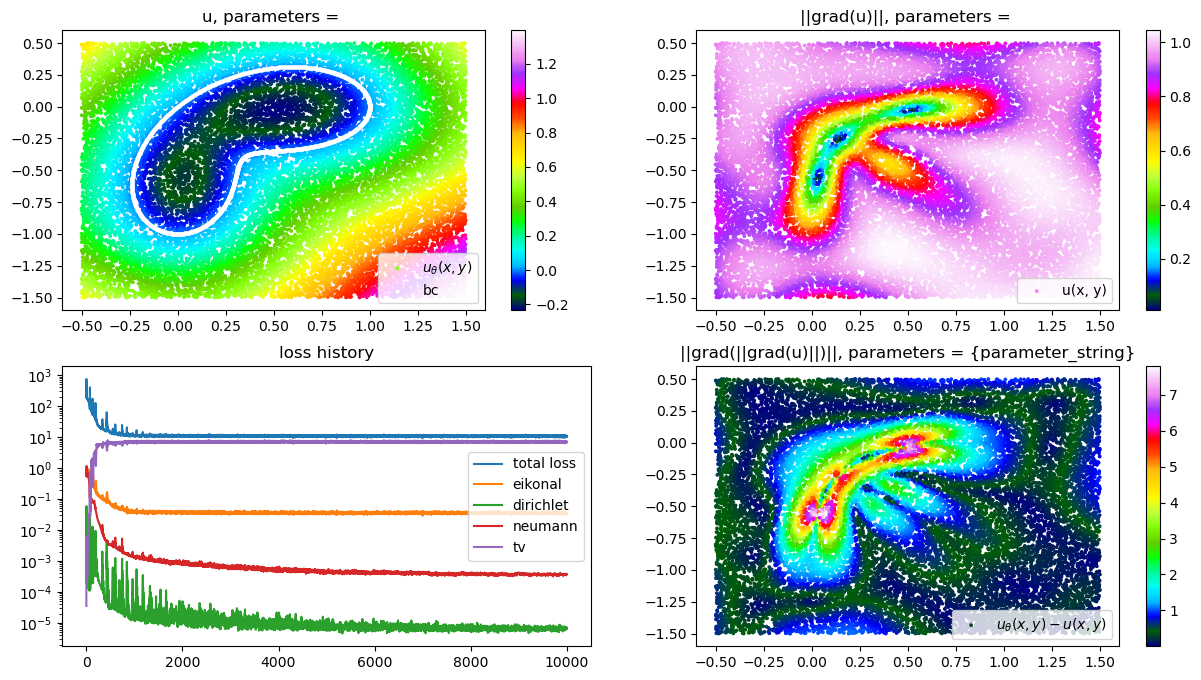

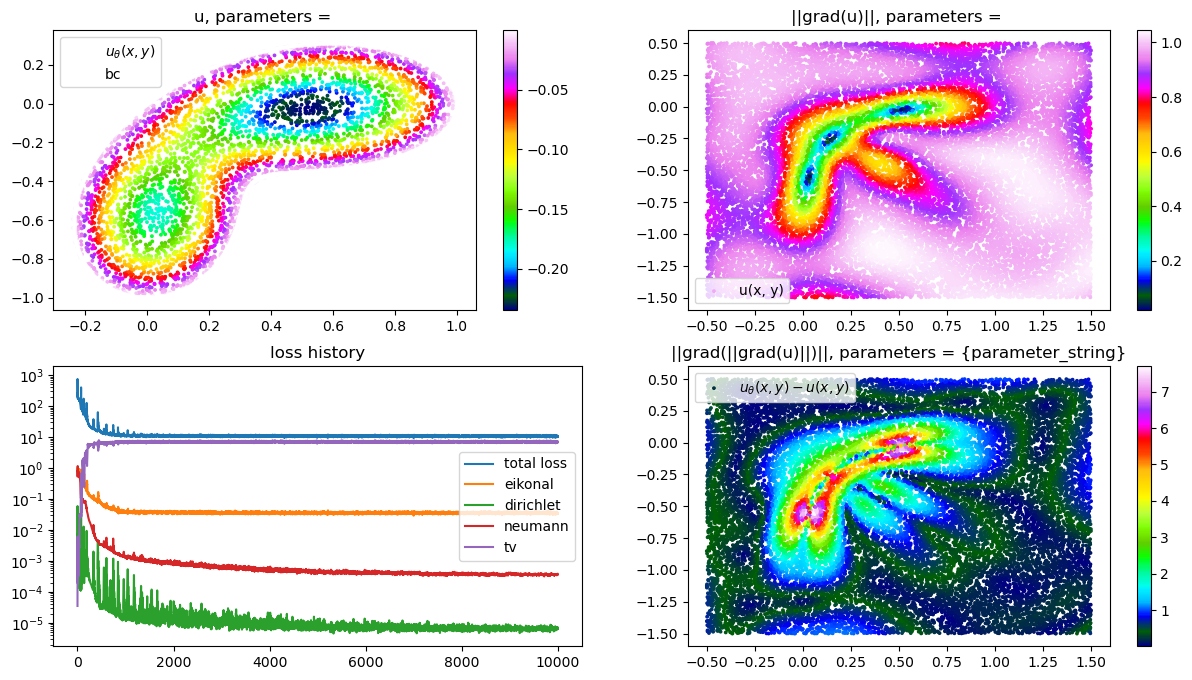

In [6]:
dict_config = read_config(config_filename)
eik,trainer = sdf_run(form,num_config,dict_config,new_training = False,createxyzfile=False)

## Construction du maillage standard

In [7]:
# mesh_dir = dir_name + "meshes/"
mesh_dir = "meshes/"
if not os.path.exists(mesh_dir):
    os.makedirs(mesh_dir)
mesh = standard_mesh(form,trainer,mesh_dir,0.01,0.05,n=201)

Reading new mesh from file


In [8]:
mesh.hmax()

0.13815630054803618

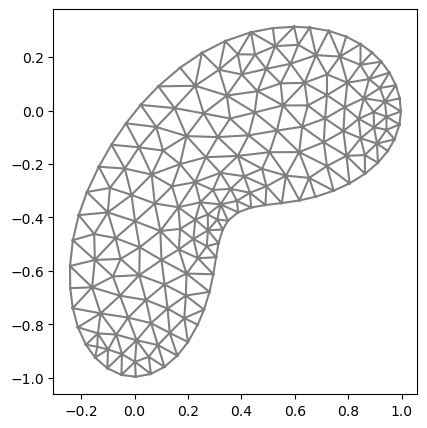

In [9]:
plt.figure(figsize=(5,5))
plot(mesh)

## Show boundary

In [10]:
approach_bc = get_boundary_vertices(mesh)
exact_bc = eik.bc_points.cpu().detach().numpy()

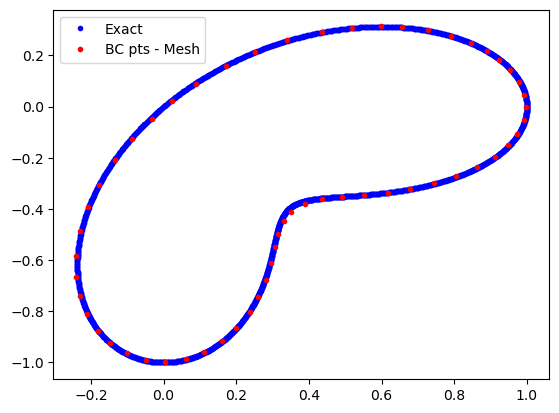

In [11]:
plt.figure()
plt.plot(exact_bc[:,0],exact_bc[:,1],'b.',label="Exact")
plt.plot(approach_bc[:,0],approach_bc[:,1],'r.',label="BC pts - Mesh")
plt.legend()
plt.show()

In [12]:
parameter_domain = trainer.pde.parameter_domain
X_test,mu_test = create_test_sample(approach_bc,parameter_domain)
pred = trainer.network.setup_w_dict(X_test, mu_test)
phi = pred["w"][:,0].cpu().detach().numpy()

In [13]:
print("Mean :",np.mean(np.abs(phi)))
print("Max :",np.max(np.abs(phi)))

Mean : 4.626641503091591e-05
Max : 0.00021881750560376334


## Convergence

In [14]:
tab_n = [20*i+1 for i in range(1,11)]
bc_error = []
for n in tab_n:
    parameter_domain = trainer.pde.parameter_domain
    XY = get_XY(form.bound_box,n)
    X_test,mu_test = create_test_sample(XY,parameter_domain)
    M,phiP1 = get_levelset(trainer,X_test,mu_test,n)

    hmin,hmax = 0.01,0.05
    filename = "levelset_mesh/"+form_name+"_"+str(n)
    if not os.path.exists(filename+".xml"):
        construct_mesh(M,phiP1,hmin,hmax,filename)
    mesh = get_df_mesh(form.bound_box,filename)

    approach_bc = get_boundary_vertices(mesh)
    exact_bc = eik.bc_points.cpu().detach().numpy()

    X_test,mu_test = create_test_sample(approach_bc,parameter_domain)
    pred = trainer.network.setup_w_dict(X_test, mu_test)
    phi = pred["w"][:,0].cpu().detach().numpy()

    bc_error.append(np.mean(np.abs(phi)))

Reading new mesh from file
Reading new mesh from file
Reading new mesh from file
Reading new mesh from file
Reading new mesh from file
Reading new mesh from file
Reading new mesh from file
Reading new mesh from file
Reading new mesh from file
Reading new mesh from file


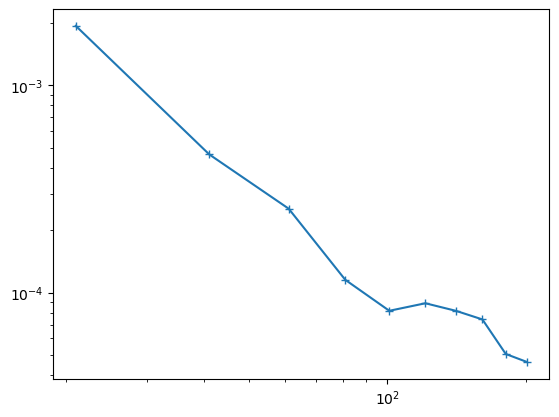

In [15]:
plt.figure()
plt.loglog(tab_n,bc_error,"+-")
plt.show()

In [16]:
tab_n = [20*i+1 for i in range(1,11)]
bc_error = []
for n in tab_n:
    parameter_domain = trainer.pde.parameter_domain
    XY = get_XY(form.bound_box,n)
    X_test,mu_test = create_test_sample(XY,parameter_domain)
    M,phiP1 = get_levelset(trainer,X_test,mu_test,n)

    hmin,hmax = 0.001,0.005
    filename = "levelset_mesh/"+form_name+"_"+str(n)+"_2"
    if not os.path.exists(filename+".xml"):
        construct_mesh(M,phiP1,hmin,hmax,filename)
    mesh = get_df_mesh(form.bound_box,filename)

    approach_bc = get_boundary_vertices(mesh)
    exact_bc = eik.bc_points.cpu().detach().numpy()

    X_test,mu_test = create_test_sample(approach_bc,parameter_domain)
    pred = trainer.network.setup_w_dict(X_test, mu_test)
    phi = pred["w"][:,0].cpu().detach().numpy()

    bc_error.append(np.mean(np.abs(phi)))

Reading new mesh from file
Reading new mesh from file
Reading new mesh from file
Reading new mesh from file
Reading new mesh from file
Reading new mesh from file
Reading new mesh from file
Reading new mesh from file
Reading new mesh from file
Reading new mesh from file


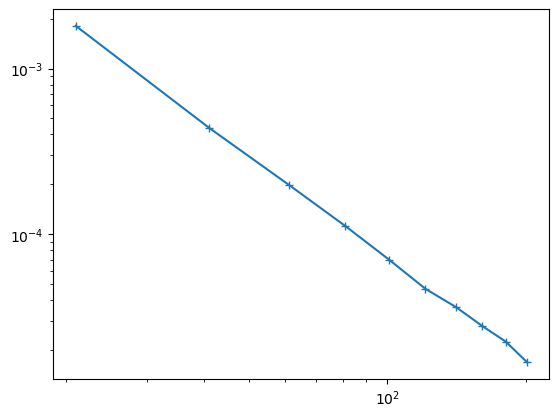

In [17]:
plt.figure()
plt.loglog(tab_n,bc_error,"+-")
plt.show()
